In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, DMatrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
# from imblearn.over_sampling import SMOTENC
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, log_loss
from collections import Counter
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

from typing import List, Dict
from sklearn.metrics import log_loss, accuracy_score, balanced_accuracy_score
import numpy as np 
import matplotlib.pyplot as plt

from collections import OrderedDict
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns
from sklearn.metrics import confusion_matrix

# File path
input_file = r"~/Downloads/CHI-JA-WLOOP-ATT-HTTP-MERGED.csv"

# Read the CSV file without specifying columns to inspect the column names
df = pd.read_csv(input_file)

# List of columns you want to keep in the output CSV
columns_to_keep = [
    "5G KPI PCell RF Serving PCI", 
    "5G KPI PCell RF Frequency [MHz]", 
    "5G KPI PCell RF Subcarrier Spacing",
#     "5G KPI PCell RF Duplex Mode",
    "5G KPI PCell RF Tx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 0",
    "5G KPI PCell RF Rx Beam ID 1",
#     "5G KPI PCell RF Serving SSB Idx", #REMOVED
    "5G KPI PCell RF Serving SS-RSRP [dBm]", 
    "5G KPI PCell RF Serving SS-RSRQ [dB]",
    "5G KPI PCell RF Serving SS-SINR [dB]",
    "5G KPI PCell RF Pathloss [dB]",
    "5G KPI PCell RF RI",
    "5G KPI PCell RF RI1 Rate [%]",
    "5G KPI PCell RF RI2 Rate [%]",
    "5G KPI PCell RF CQI",
    "5G KPI PCell RF PMI i(1;1)",
    "5G KPI PCell RF PMI i(1;2)",
    "5G KPI PCell RF PMI i(1;3)",
    "5G KPI PCell RF PMI i(2)",
    "5G KPI PCell RF LI",
    "5G KPI PCell RF TA",
    "5G KPI PCell RF PRACH Power [dBm]",
    "5G KPI PCell RF PUSCH Power [dBm]", 
    "5G KPI PCell RF PUCCH Power [dBm]",
    "5G KPI PCell RF SRS Power [dBm]",
    "5G KPI PCell RF ENDC Tx Power [dBm]",
    "5G KPI PCell RF Neighbor Top1 PCI",
    "5G KPI PCell RF Neighbor Top1 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top1 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top2 PCI",
    "5G KPI PCell RF Neighbor Top2 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top2 SS-RSRQ [dB]",
    "5G KPI PCell RF Neighbor Top3 PCI",
    "5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]",
    "5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]",
    "5G KPI PCell Layer1 DL BLER [%]",
    "5G KPI PCell Layer1 UL BLER [%]",
    "5G KPI PCell Layer1 DL RB Num (Avg)",
    "5G KPI PCell Layer1 UL RB Num (Avg)",
    "5G KPI PCell Layer1 PDSCH Throughput [Mbps]",
    "5G KPI PCell Layer1 PUSCH Throughput [Mbps]"
]

# Read the input CSV file
df = pd.read_csv(input_file, low_memory=False)

# Check the initial shape of the DataFrame
print("Initial shape:", df.shape)

# Filter columns
df = df[columns_to_keep]

df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})

# Clean column names
cleaned_columns = [col.replace('[', '').replace(']', '').replace('%', 'Percent').replace(' ', '').replace('(', '').replace(')', '') for col in df.columns]
df.columns = cleaned_columns

# Dictionary to map the original to cleaned column names for clarity
column_mapping = dict(zip(columns_to_keep, cleaned_columns))

# Keep only records up to and including line 26017
df = df.iloc[:26018]

def average_consecutive_nan(column):
  nan_lengths = []
  current_length = 0
  for value in column.isnull():
    if value:
      current_length += 1
    else:
      if current_length > 0:
        nan_lengths.append(current_length)
      current_length = 0
  if current_length > 0:
    nan_lengths.append(current_length)
  return np.mean(nan_lengths) if nan_lengths else 0

for col in [column_mapping["5G KPI PCell RF Serving PCI"], 
            column_mapping["5G KPI PCell RF Frequency [MHz]"],
            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
            column_mapping["5G KPI PCell RF Neighbor Top2 PCI"],
            column_mapping["5G KPI PCell RF PMI i(1;1)"],
            column_mapping["5G KPI PCell RF PMI i(1;2)"],
            column_mapping["5G KPI PCell RF PMI i(1;3)"]]:
                df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])
for col in [
           column_mapping["5G KPI PCell RF Subcarrier Spacing"],
           column_mapping["5G KPI PCell RF Rx Beam ID 0"],
           column_mapping["5G KPI PCell RF Rx Beam ID 1"],
#            column_mapping["5G KPI PCell RF Serving SSB Idx"], #REMOVED
           column_mapping["5G KPI PCell RF RI"],
#            column_mapping["5G KPI PCell RF PMI i(1;1)"],
           column_mapping["5G KPI PCell RF PMI i(2)"],
           column_mapping["5G KPI PCell RF LI"],
           column_mapping["5G KPI PCell RF TA"],
#            column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
#            column_mapping["5G KPI PCell RF Neighbor Top2 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top3 PCI"]]:
                if df[col].mode().empty:
                    df[col] = df[col].fillna(df[col].median())
                else:
                    df[col] = df[col].fillna(df[col].mode().iloc[0])

columns_to_remove = [
    column_mapping["5G KPI PCell RF Rx Beam ID 0"],
    column_mapping["5G KPI PCell RF PRACH Power [dBm]"],#<0.05
    column_mapping["5G KPI PCell RF Rx Beam ID 1"],
    column_mapping["5G KPI PCell RF ENDC Tx Power [dBm]"],
    column_mapping["5G KPI PCell RF SRS Power [dBm]"],
    column_mapping["5G KPI PCell RF Subcarrier Spacing"],
#     column_mapping["5G KPI PCell RF Duplex Mode"],
    column_mapping["5G KPI PCell RF RI"],
    column_mapping["5G KPI PCell RF RI1 Rate [%]"],
    column_mapping["5G KPI PCell RF RI2 Rate [%]"],
    column_mapping["5G KPI PCell RF PMI i(1;1)"],
    column_mapping["5G KPI PCell RF PMI i(2)"],
    column_mapping["5G KPI PCell RF PMI i(1;2)"],
    column_mapping["5G KPI PCell RF PMI i(1;3)"],
    column_mapping["5G KPI PCell RF LI"], #LI always 1 here so its just noise
    column_mapping["5G KPI PCell RF TA"],
    column_mapping["5G KPI PCell RF Neighbor Top3 PCI"],#<0.05
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRP [dBm]"],#<0.05
    column_mapping["5G KPI PCell RF Neighbor Top3 SS-RSRQ [dB]"]#<0.05
#     column_mapping["5G KPI PCell RF SRS Power [dBm]"]
]
# Ensure all columns to remove are mapped correctly
# print("Columns to remove (mapped):", columns_to_remove)

# Drop the columns
df = df.drop(columns=columns_to_remove)

# Verify the columns after dropping
# print("Remaining columns after dropping:")
# print(df.columns)          
# Impute remaining NaNs with column mean
for col in df.columns:
    if col not in [
           column_mapping["5G KPI PCell RF Tx Beam ID 0"],
           column_mapping["5G KPI PCell RF Serving PCI"],
           column_mapping["5G KPI PCell RF Frequency [MHz]"],
           column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
           column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]
                  ]:
                df[col] = df[col].fillna(df[col].mean())
# df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]] = df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].fillna(df[column_mapping["5G KPI PCell RF PRACH Power [dBm]"]].mean())

# Remove columns from DataFrame
df = df.dropna(subset=[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]) # Drop AFTER CLEANING!
# print(Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))

# print(df.columns)

categorical_columns=[
#         column_mapping["5G KPI PCell RF Tx Beam ID 0"], #target
        column_mapping["5G KPI PCell RF Serving PCI"],
        column_mapping["5G KPI PCell RF Neighbor Top1 PCI"],
        column_mapping["5G KPI PCell RF Neighbor Top2 PCI"]]
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != column_mapping["5G KPI PCell RF Tx Beam ID 0"]]
# print(numerical_columns)

for col in categorical_columns:
    df[col] = df[col].astype('category')
for col in df.columns:
    if col not in categorical_columns:
        df[col] = df[col].astype('float')
df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]].astype('category') #target
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top1 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Neighbor Top2 PCI"])
df = df.drop(columns=column_mapping["5G KPI PCell RF Serving PCI"])
# print(df.columns)
# Split the data into features and target
X = df.drop(column_mapping["5G KPI PCell RF Tx Beam ID 0"], axis=1)
y = df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]
print("before dropping bad classes: ", Counter(df[column_mapping["5G KPI PCell RF Tx Beam ID 0"]]))

# REMOVE SMALL CLASSES
mask = ~y.isin([13.0, 38.0, 26.0, 15.0, 37.0, 24.0, 39.0, 23.0, 30.0, 43.0, 21.0, 33.0, 42.0, 12.0, 20.0, 22.0,
         31.0, 8.0, 14.0, 63.0, 45.0, 47.0, 35.0, 52.0, 53.0, 46.0, 6.0, 59.0, 58.0,
         56.0, 54.0, 57.0, 55.0, 44.0, 61.0, 2.0, 60.0, 11.0, 9.0, 40.0, 36.0, 7.0, 28.0, 25.0, 41.0
        # ])
         , 3.0, 4.0, 5.0, 32.0, 10.0, 29.0])
        #  , 32.0, 10.0, 29.0])
X= X[mask]
y= y[mask]
print("after dropping bad classes: ", Counter(y))

/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23581/2911725074.py:36: DtypeWarning: Columns (10,81,82,84,85,89,97,140,141,143,144,151,182,183,185,186,193,202,203,205,206,213,222,223,225,226,233,242,243,245,246,253,262,263,265,266,273,282,283,285,286,293) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file)


Initial shape: (26016, 306)


/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23581/2911725074.py:93: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['5G KPI PCell RF Subcarrier Spacing'] = df['5G KPI PCell RF Subcarrier Spacing'].replace({'120kHz': 0.12, '15kHz': 0.015})
/var/folders/t3/736m4c7914ggm6c17vd2z3nr0000gn/T/ipykernel_23581/2911725074.py:126: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill', limit=int(average_consecutive_nan(df[col]))).fillna(df[col].mode().iloc[0])


before dropping bad classes:  Counter({34.0: 543, 0.0: 409, 62.0: 307, 27.0: 307, 1.0: 299, 29.0: 206, 5.0: 163, 3.0: 158, 4.0: 139, 32.0: 122, 10.0: 103, 11.0: 94, 9.0: 86, 40.0: 73, 36.0: 64, 7.0: 62, 28.0: 57, 25.0: 55, 41.0: 52, 13.0: 49, 38.0: 49, 26.0: 40, 15.0: 39, 37.0: 39, 24.0: 37, 39.0: 36, 23.0: 36, 30.0: 35, 43.0: 28, 21.0: 28, 33.0: 22, 42.0: 21, 12.0: 19, 20.0: 19, 22.0: 18, 31.0: 18, 8.0: 15, 14.0: 15, 63.0: 13, 45.0: 11, 47.0: 11, 35.0: 11, 52.0: 9, 53.0: 9, 46.0: 8, 6.0: 7, 59.0: 7, 58.0: 6, 56.0: 6, 54.0: 6, 57.0: 6, 55.0: 6, 44.0: 5, 61.0: 3, 2.0: 3, 60.0: 2})
after dropping bad classes:  Counter({34.0: 543, 0.0: 409, 62.0: 307, 27.0: 307, 1.0: 299})


In [2]:
# Cell 1: Imports and Data Preparation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score, average_precision_score, make_scorer
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb

# Assume X and y are already defined

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weight_dict = dict(zip(np.unique(y_train), class_weights))

# Assign sample weights
sample_weights = np.array([weight_dict[label] for label in y_train])

# Convert data to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
# dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [3]:
results_df = pd.read_pickle('att_xgb_rand_search_results.pkl')

# # Cell 2: Custom Scorer and Random Search
# def custom_scorer(estimator, X, y):
#     y_pred = estimator.predict(X)
#     return balanced_accuracy_score(y, y_pred)

# class CustomRandomizedSearchCV(RandomizedSearchCV):
#     def fit(self, X, y, **fit_params):
#         super().fit(X, y, **fit_params)
#         self.train_scores_ = []
#         self.test_scores_ = []
#         for params, cv_results in zip(self.cv_results_['params'], self.cv_results_['split0_test_score']):
#             estimator = self.estimator.set_params(**params)
#             estimator.fit(X, y, **fit_params)
#             self.train_scores_.append(custom_scorer(estimator, X, y))
#             self.test_scores_.append(cv_results)
#         return self

# # Define the parameter space
# param_dist = {
#     'max_depth': randint(3, 10),
#     'learning_rate': uniform(0.01, 0.2),
#     'min_child_weight': randint(1, 10),
#     'subsample': uniform(0.5, 0.5),
#     'colsample_bytree': uniform(0.5, 0.5),
#     'alpha': uniform(0, 5),
#     'lambda': uniform(0, 5),
#     'gamma': uniform(0, 5)
# }

# # Create the XGBoost classifier
# xgb_model = xgb.XGBClassifier(
#     objective='multi:softprob',
#     num_class=len(np.unique(y_encoded)),
#     eval_metric=['mlogloss', 'merror'],
#     random_state=42
# )

# # Set up CustomRandomizedSearchCV
# random_search = CustomRandomizedSearchCV(
#     xgb_model,
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring=make_scorer(balanced_accuracy_score),
#     n_jobs=-1,
#     cv=3,
#     verbose=1,
#     random_state=42
# )

# # Perform random search
# random_search.fit(X_train, y_train, sample_weight=sample_weights)

# # Create a DataFrame with results
# results_df = pd.DataFrame({
#     'params': random_search.cv_results_['params'],
#     'train_score': random_search.train_scores_,
#     'test_score': random_search.test_scores_
# })

# # Calculate the difference between train and test scores
# results_df['score_difference'] = results_df['train_score'] - results_df['test_score']


In [4]:

# Sort by the smallest difference
results_df = results_df.sort_values('score_difference')

# Saving in csv (human readable) and pickle (if you need to open it in code) format
results_df.to_pickle('att_xgb_rand_search_results.pkl')
results_df.to_csv('att_xgb_rand_search_results.csv', index=False)

# Display the top 10 models with the smallest difference
print("Top 10 models with smallest difference between train and test balanced accuracy:")
print(results_df[['train_score', 'test_score', 'score_difference']].head(40))


Top 10 models with smallest difference between train and test balanced accuracy:
    train_score  test_score  score_difference
96     0.734380    0.680163          0.054216
31     0.748590    0.689266          0.059324
85     0.744938    0.682846          0.062092
23     0.754660    0.688525          0.066135
30     0.761633    0.694226          0.067407
51     0.747746    0.678546          0.069199
36     0.757896    0.686665          0.071232
72     0.754745    0.681467          0.073278
68     0.755566    0.679987          0.075579
37     0.759109    0.682304          0.076805
43     0.744605    0.665651          0.078954
88     0.784260    0.704642          0.079618
8      0.759554    0.678212          0.081342
24     0.769191    0.687846          0.081345
7      0.761983    0.680407          0.081575
71     0.757822    0.675849          0.081973
62     0.766402    0.682846          0.083556
32     0.780687    0.696528          0.084159
79     0.766108    0.681528          0.084580

In [5]:

# Creating a copy dataframe sorted by highest test score to see which model to choose manually
results_df_by_test_score = results_df.copy()
results_df_by_test_score = results_df_by_test_score.sort_values('test_score', ascending=False)
print(results_df_by_test_score[['train_score', 'test_score', 'score_difference']].head(40))

# Manually selecting best model - could choose no. 88 (test acc 0.704642) or no. 30 (test acc 0.694226)
# Choosing no. 30 b/c lower score_difference
print(results_df.iloc[4][['params', 'train_score', 'test_score', 'score_difference']])
best_params = results_df.iloc[4]['params']
# best_model = xgb_model.set_params(**best_params)
# best_model.fit(X_train, y_train, sample_weight=sample_weights)

print("\nBest model parameters:")
print(best_params)

    train_score  test_score  score_difference
16     0.944649    0.750281          0.194367
42     0.944466    0.741067          0.203399
19     0.945724    0.729490          0.216233
45     0.921900    0.729293          0.192607
4      0.902416    0.728912          0.173504
81     0.903471    0.727310          0.176160
28     0.903704    0.724911          0.178793
60     0.876652    0.723136          0.153515
84     0.879623    0.721316          0.158307
10     0.898826    0.719196          0.179630
13     0.897311    0.717396          0.179914
22     0.825788    0.714358          0.111430
39     0.853895    0.709800          0.144095
78     0.848702    0.705479          0.143223
59     0.896680    0.705241          0.191439
88     0.784260    0.704642          0.079618
44     0.869215    0.704541          0.164674
77     0.790820    0.704520          0.086300
94     0.805364    0.700062          0.105302
33     0.808434    0.699961          0.108472
11     0.850573    0.698902       

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import make_scorer, balanced_accuracy_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns

# From random search (excluding 3,4,5,32,10,29)
params = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_encoded)),
    'eval_metric': ['mlogloss', 'merror'],

    'alpha': 4.865052773762228, 
    'colsample_bytree': 0.6965488623333802, 
    'gamma': 4.460232775885567, 
    'lambda': 3.1556931299863145, 
    'learning_rate': 0.1689622607083297, 
    'max_depth': 8, 
    'min_child_weight': 1, 
    'subsample': 0.7884519423131795
}

# Custom evaluation function for balanced accuracy
def balanced_accuracy_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(y_pred.reshape(len(y_true), -1), axis=1)
    return 'balanced_accuracy', balanced_accuracy_score(y_true, y_pred)

# Train the final model with verbose_eval=True to get the evaluation history
evals_result = {}
final_model = xgb.train(
    params,
    dtrain,
    num_boost_round=5000,
    evals=[(dtrain, 'train'), 
            # (dval, 'eval'), 
            (dtest, 'test')],
    early_stopping_rounds=200, # Early stopping did worse here (200 causes 1% drop in accuracy)
    verbose_eval=False,
    evals_result=evals_result,
    custom_metric=balanced_accuracy_eval
)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred_proba):
    y_pred = np.argmax(y_pred_proba, axis=1)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
        'auroc': roc_auc_score(y_true, y_pred_proba, multi_class='ovr'),
        'auprc': average_precision_score(y_true, y_pred_proba, average='weighted')
    }

# Make predictions on the training and test sets
y_train_pred_proba = final_model.predict(dtrain)
y_test_pred_proba = final_model.predict(dtest)

# Calculate final training and test metrics
train_metrics = calculate_metrics(y_train, y_train_pred_proba)
test_metrics = calculate_metrics(y_test, y_test_pred_proba)

print("\nFinal Training Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")

print("\nFinal Test Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric.capitalize()}: {value:.4f}")



Final Training Metrics:
Accuracy: 0.7527
Balanced_accuracy: 0.7679
Auroc: 0.9408
Auprc: 0.8314

Final Test Metrics:
Accuracy: 0.6783
Balanced_accuracy: 0.6871
Auroc: 0.9063
Auprc: 0.7596


In [12]:

# Perform bootstrapping
def bootstrap_metrics(model, X, y, n_iterations=100):
    results = []
    for _ in range(n_iterations):
        # Sample with replacement
        bootstrap_indices = np.random.choice(len(X), size=len(X), replace=True)
        X_bootstrap = X.iloc[bootstrap_indices]
        y_bootstrap = y[bootstrap_indices]
        dmatrix = xgb.DMatrix(X_bootstrap)
        y_pred_proba = model.predict(dmatrix)
        results.append(calculate_metrics(y_bootstrap, y_pred_proba))
    return pd.DataFrame(results)
    
bootstrap_results = bootstrap_metrics(final_model, X_test, y_test)

print("\nOpY XGBoost - Bootstrapped Test Metrics (Mean ± Std):")
for metric in bootstrap_results.columns:
    mean = bootstrap_results[metric].mean()
    std = bootstrap_results[metric].std()
    print(f"{metric.capitalize()}: {mean:.4f} (± {std:.4f})")


OpY XGBoost - Bootstrapped Test Metrics (Mean ± Std):
Accuracy: 0.6766 (± 0.0236)
Balanced_accuracy: 0.6840 (± 0.0226)
Auroc: 0.9059 (± 0.0089)
Auprc: 0.7637 (± 0.0212)



Top Feature Importances weight:
<bound method NDFrame.head of                                 feature  importance
8    5GKPIPCellRFNeighborTop1SS-RSRPdBm        43.0
11    5GKPIPCellRFNeighborTop2SS-RSRQdB        33.0
0              5GKPIPCellRFFrequencyMHz        32.0
9     5GKPIPCellRFNeighborTop1SS-RSRQdB        32.0
15           5GKPIPCellLayer1ULRBNumAvg        26.0
4                5GKPIPCellRFPathlossdB        18.0
10   5GKPIPCellRFNeighborTop2SS-RSRPdBm        18.0
17  5GKPIPCellLayer1PUSCHThroughputMbps        16.0
7             5GKPIPCellRFPUCCHPowerdBm        15.0
1         5GKPIPCellRFServingSS-RSRPdBm        14.0
14           5GKPIPCellLayer1DLRBNumAvg        14.0
6             5GKPIPCellRFPUSCHPowerdBm        12.0
16  5GKPIPCellLayer1PDSCHThroughputMbps        12.0
2          5GKPIPCellRFServingSS-RSRQdB         9.0
3          5GKPIPCellRFServingSS-SINRdB         7.0
5                       5GKPIPCellRFCQI         5.0
12        5GKPIPCellLayer1DLBLERPercent         2.0
1

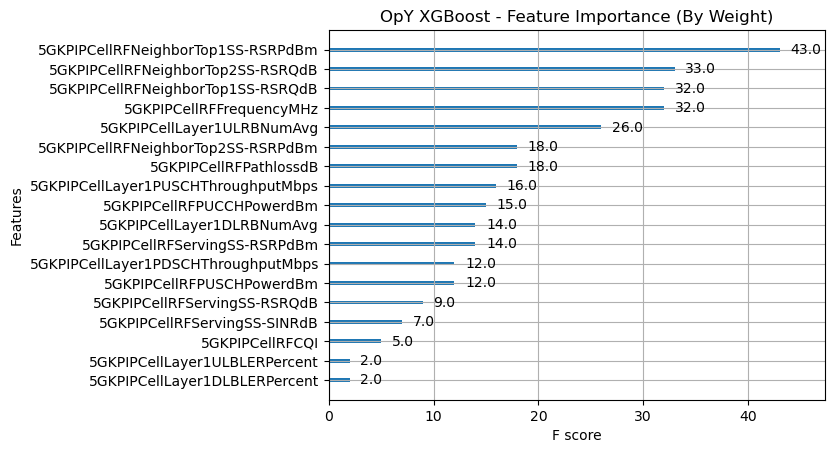

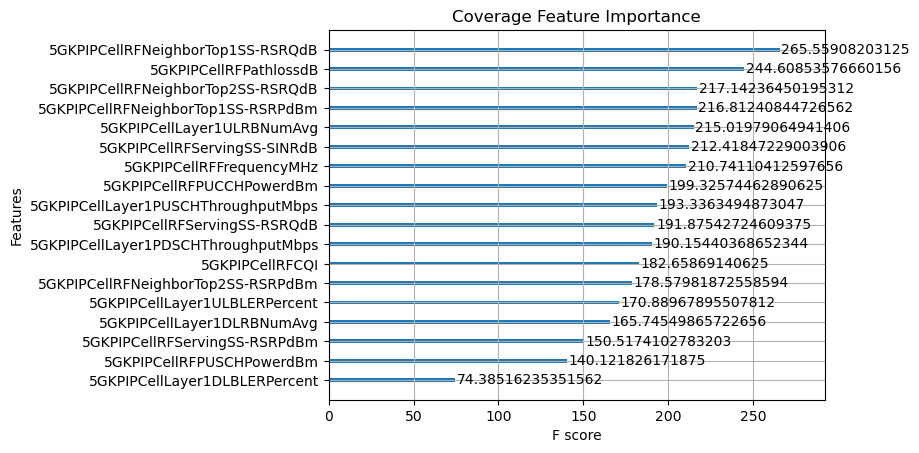

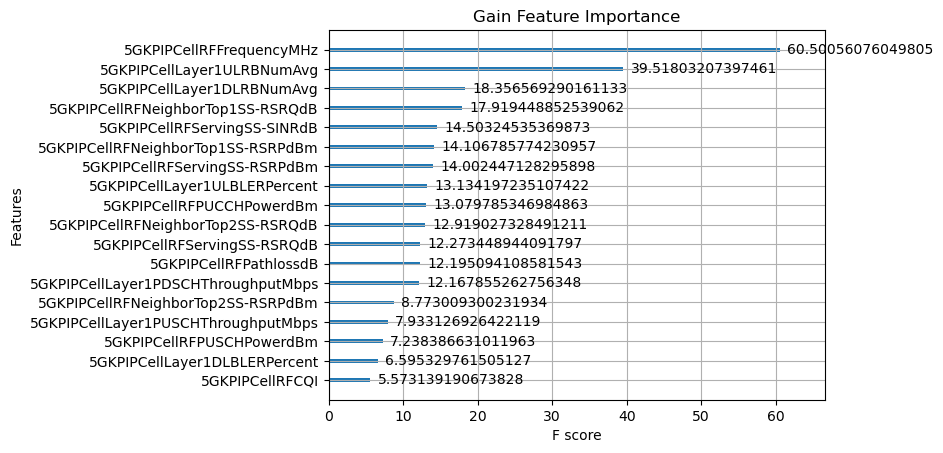

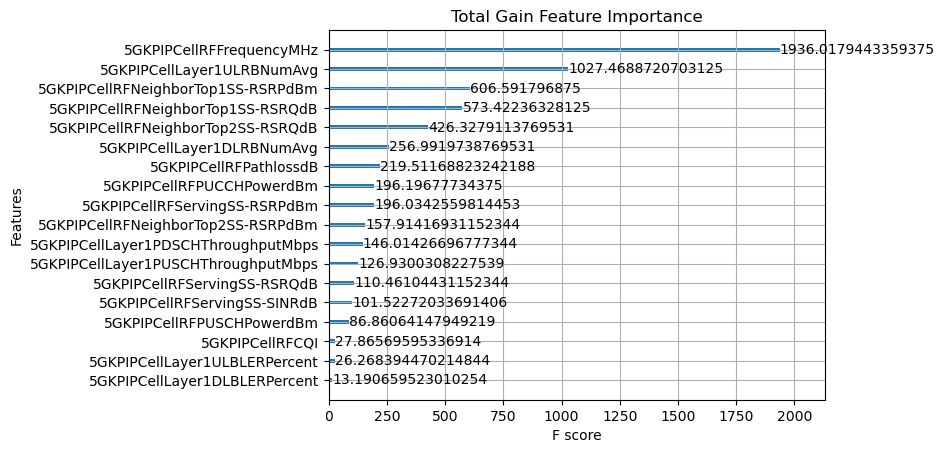

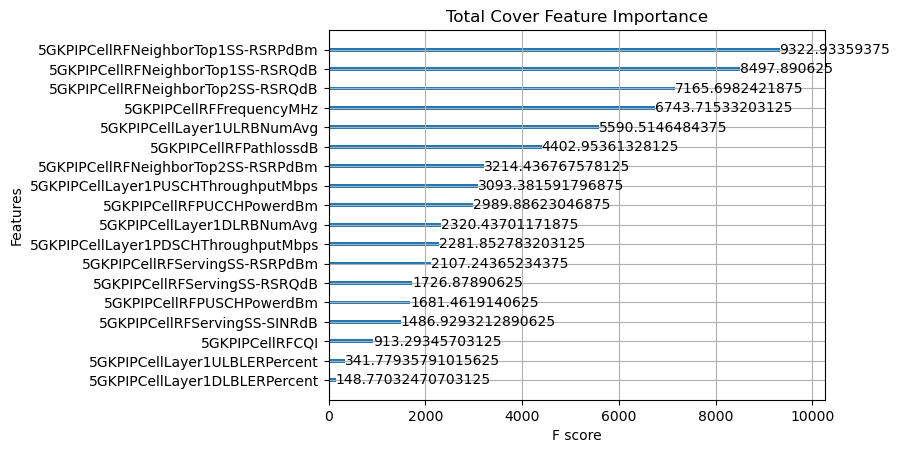

In [8]:

# Feature importance
importance_scores = final_model.get_score(importance_type='weight')
importance_df = pd.DataFrame({'feature': importance_scores.keys(), 'importance': importance_scores.values()})
importance_df = importance_df.sort_values('importance', ascending=False)

print("\nTop Feature Importances weight:")
print(importance_df.head)

xgb.plot_importance(final_model, importance_type="weight")
plt.title('OpY XGBoost - Feature Importance (By Weight)')
plt.show()
xgb.plot_importance(final_model, importance_type= "cover")
plt.title('Coverage Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "gain")
plt.title('Gain Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "total_gain")
plt.title('Total Gain Feature Importance')
plt.show()
xgb.plot_importance(final_model, importance_type= "total_cover")
plt.title('Total Cover Feature Importance')
plt.show()

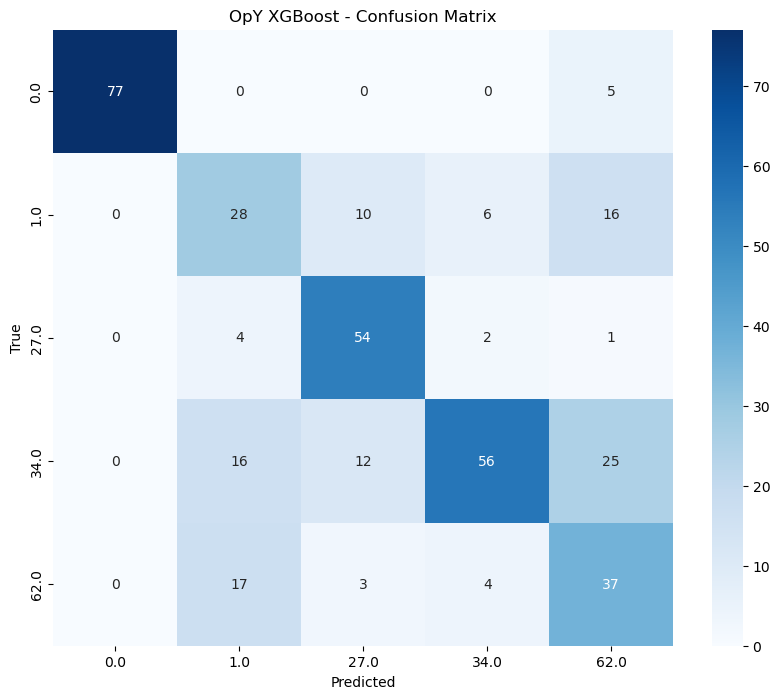

In [9]:
# Plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('OpY XGBoost - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
y_test_pred = np.argmax(y_test_pred_proba, axis=1)
plot_confusion_matrix(y_test, y_test_pred, classes=le.classes_)

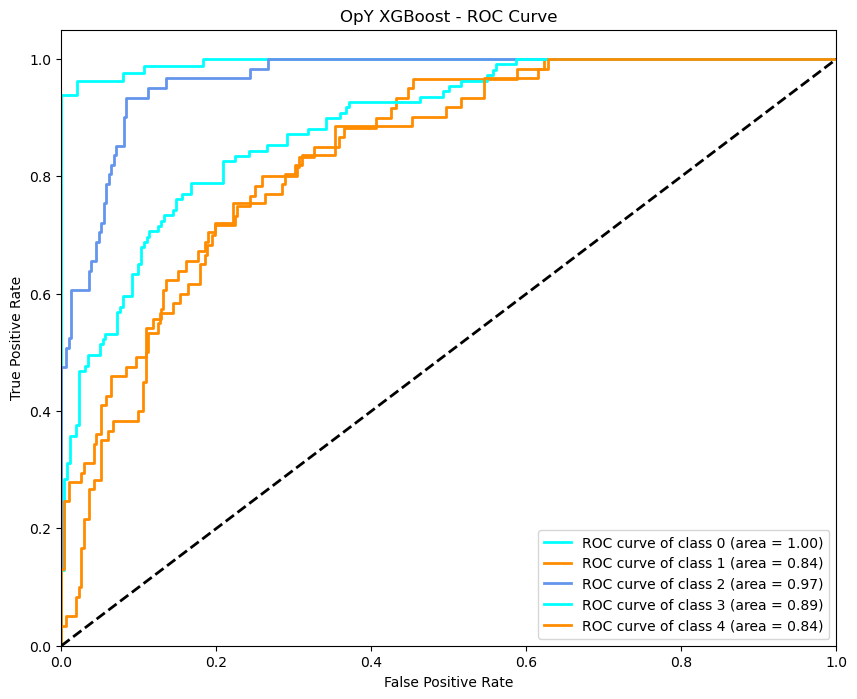

In [10]:
# ROC Curve plot
from sklearn.metrics import roc_curve, auc
from itertools import cycle

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test))

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_test_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('OpY XGBoost - ROC Curve')
plt.legend(loc="lower right")
plt.show()

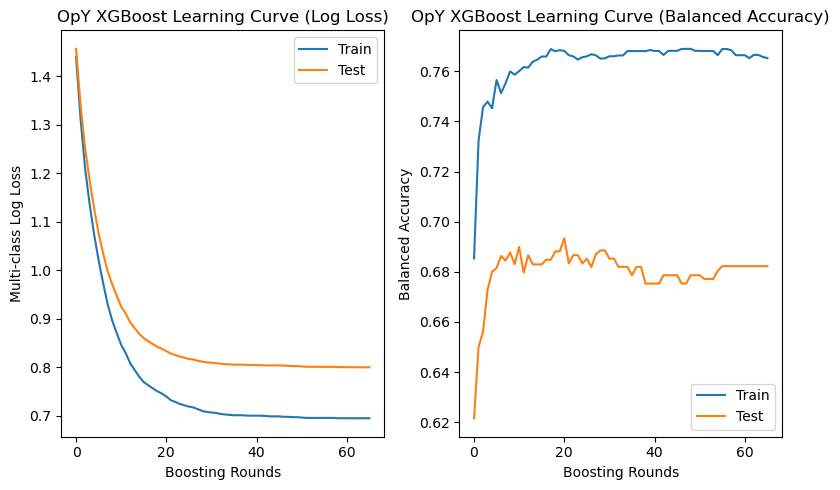

In [11]:
# Plot learning curves
def plot_learning_curves(evals_result):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(evals_result['train']['mlogloss'], label='Train')
    # plt.plot(evals_result['eval']['mlogloss'], label='Validation')
    plt.plot(evals_result['test']['mlogloss'], label='Test')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Multi-class Log Loss')
    plt.title('OpY XGBoost Learning Curve (Log Loss)')
    plt.legend()
    
    # plt.subplot(1, 3, 3)
    # plt.plot(evals_result['train']['merror'], label='Train')
    # # plt.plot(evals_result['eval']['merror'], label='Validation')
    # plt.plot(evals_result['test']['merror'], label='Test')
    # plt.xlabel('Boosting Rounds')
    # plt.ylabel('Classification Error')
    # plt.title('Learning Curve - Classification Error')
    # plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(evals_result['train']['balanced_accuracy'], label='Train')
    # plt.plot(evals_result['eval']['balanced_accuracy'], label='Validation')
    plt.plot(evals_result['test']['balanced_accuracy'], label='Test')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('Balanced Accuracy')
    plt.title('OpY XGBoost Learning Curve (Balanced Accuracy)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
plot_learning_curves(evals_result)